# Superhero (and Supervillain) Name Generator

---

[Superhero Names Dataset](https://github.com/am1tyadav/superhero)

## Task 2

1. Import the data
2. Create a tokenizer
3. Char to index and Index to char dictionaries

In [1]:
!git clone https://github.com/am1tyadav/superhero

Cloning into 'superhero'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 8 (delta 0), reused 4 (delta 0), pack-reused 0
Unpacking objects: 100% (8/8), 47.06 KiB | 1.68 MiB/s, done.


In [5]:
with open('superhero/superheroes.txt') as file:
    data = file.read()

print(data[:95])

jumpa	
doctor fate	
starlight	
isildur	
lasher	
varvara	
the target	
axel	
battra	
changeling	



In [6]:
import tensorflow as tf
print(tf.version.VERSION)

2.12.0


In [17]:
# a = data.split('\n')

In [53]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~',
    split='\n',
)

In [54]:
tokenizer.fit_on_texts(data)

In [55]:
char_to_index = tokenizer.word_index
index_to_char = dict((v, k) for k, v in char_to_index.items())

print(index_to_char)

{1: '\t', 2: 'a', 3: 'e', 4: 'r', 5: 'o', 6: 'n', 7: 'i', 8: ' ', 9: 't', 10: 's', 11: 'l', 12: 'm', 13: 'h', 14: 'd', 15: 'c', 16: 'u', 17: 'g', 18: 'k', 19: 'b', 20: 'p', 21: 'y', 22: 'w', 23: 'f', 24: 'v', 25: 'j', 26: 'z', 27: 'x', 28: 'q'}


In [56]:
print(len(char_to_index))

28


## Task 3

1. Converting between names and sequences

In [57]:
names = data.split('\n')
names[:10]

['jumpa\t',
 'doctor fate\t',
 'starlight\t',
 'isildur\t',
 'lasher\t',
 'varvara\t',
 'the target\t',
 'axel\t',
 'battra\t',
 'changeling\t']

In [58]:
tokenizer.texts_to_sequences(names[0])

[[25], [16], [12], [20], [2], [1]]

In [59]:
def name_to_seq(name):
    return [tokenizer.texts_to_sequences(c)[0][0] for c in name]

In [60]:
name_to_seq(names[0])

[25, 16, 12, 20, 2, 1]

In [61]:
def seq_to_name(seq):
    return ''.join([index_to_char[i] for i in seq if i != 0])

In [62]:
seq_to_name(name_to_seq(names[0]))

'jumpa\t'

## Task 4

1. Creating sequences
2. Padding all sequences

In [63]:
sequences = []

for name in names:
    seq = name_to_seq(name)
    if len(seq) >= 2:
        sequences += [seq[:i] for i in range(2, len(seq)+1)]

In [64]:
sequences[:10]

[[25, 16],
 [25, 16, 12],
 [25, 16, 12, 20],
 [25, 16, 12, 20, 2],
 [25, 16, 12, 20, 2, 1],
 [14, 5],
 [14, 5, 15],
 [14, 5, 15, 9],
 [14, 5, 15, 9, 5],
 [14, 5, 15, 9, 5, 4]]

In [65]:
max_len = max([len(x) for x in sequences])
max_len

33

In [66]:
padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(
    sequences,
    padding='pre',
    maxlen=max_len,
)

print(padded_sequences[0])

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0 25 16]


In [67]:
padded_sequences.shape

(88279, 33)

## Task 5: Creating Training and Validation Sets

1. Creating training and validation sets

In [68]:
X, y = padded_sequences[:, :-1], padded_sequences[:, -1]

X.shape, y.shape

((88279, 32), (88279,))

In [70]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(70623, 32) (70623,)
(17656, 32) (17656,)


In [71]:
num_chars = len(char_to_index.keys()) + 1
print(num_chars)

29


## Task 6: Creating the Model

In [73]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=num_chars,
                              output_dim=8,
                              input_length=max_len-1),
    tf.keras.layers.Conv1D(64, 5, strides=1, activation='tanh', padding='causal'),
    tf.keras.layers.MaxPool1D(pool_size=2),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(32, return_sequences=True)
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(num_chars, activation='softmax'),
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 32, 8)             232       
                                                                 
 conv1d_1 (Conv1D)           (None, 32, 64)            2624      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 16, 64)           0         
 1D)                                                             
                                                                 
 bidirectional (Bidirectiona  (None, 16, 64)           24832     
 l)                                                              
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense_1 (Dense)             (None, 29)               

## Task 7: Training the Model

In [74]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                         patience=3)
    ]
)

Epoch 1/50
2207/2207 [==============================] - 41s 11ms/step - loss: 2.7458 - accuracy: 0.1862 - val_loss: 2.5850 - val_accuracy: 0.2184
Epoch 2/50
2207/2207 [==============================] - 34s 16ms/step - loss: 2.5515 - accuracy: 0.2299 - val_loss: 2.5013 - val_accuracy: 0.2421
Epoch 3/50
2207/2207 [==============================] - 29s 13ms/step - loss: 2.4723 - accuracy: 0.2549 - val_loss: 2.4291 - val_accuracy: 0.2672
Epoch 4/50
2207/2207 [==============================] - 22s 10ms/step - loss: 2.4106 - accuracy: 0.2726 - val_loss: 2.3882 - val_accuracy: 0.2788
Epoch 5/50
2207/2207 [==============================] - 26s 12ms/step - loss: 2.3663 - accuracy: 0.2838 - val_loss: 2.3523 - val_accuracy: 0.2855
Epoch 6/50
2207/2207 [==============================] - 29s 13ms/step - loss: 2.3272 - accuracy: 0.2967 - val_loss: 2.3266 - val_accuracy: 0.2967
Epoch 7/50
2207/2207 [==============================] - 26s 12ms/step - loss: 2.2895 - accuracy: 0.3074 - val_loss: 2.3033 -

<Axes: >

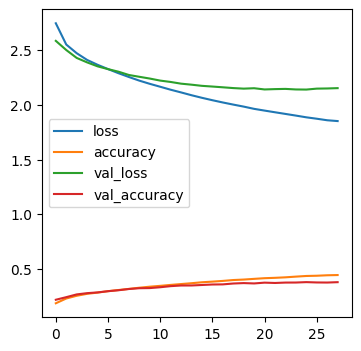

In [75]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(4, 4))

## Task 8: Generate Names!

In [80]:
def generate_names(seed):
    for i in range(0, 40):
        seq = name_to_seq(seed)
        padded = tf.keras.preprocessing.sequence.pad_sequences([seq],
                                                               padding='pre',
                                                               maxlen=max_len-1,
                                                               truncating='pre')
        pred = model.predict(padded, verbose=0)[0]
        pred_char = index_to_char[tf.argmax(pred).numpy()]
        seed += pred_char

        if pred_char == '\t':
            break
    print(seed)

In [109]:
generate_names('supr')

supreme inter	


In [110]:
import pickle as pkl

In [111]:
with open('model.pkl', 'wb') as file:
    pkl.dump(model, file)

with open('index_to_char.pkl', 'wb') as file:
    pkl.dump(index_to_char, file)